In [1]:
import pandas as pd
import numpy as np

REDWINE_PATH = "../datasets/winequality-red.csv"
WHITEWINE_PATH = "../datasets/winequality-white.csv"

# read red wine set of observations
data_red = pd.read_csv(REDWINE_PATH,sep=',')
data_red['color'] = 1 #redwine

print(data_red.shape)

# read white wine set of observations
data_white = pd.read_csv(WHITEWINE_PATH,sep=',')
data_white['color'] = 0 #whitewine

print(data_white.shape)

# merge the two sets in one
data = data_red.merge(data_white, how='outer')
fields = list(data.columns)
print(fields)

(1599, 13)
(4898, 13)
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'color']


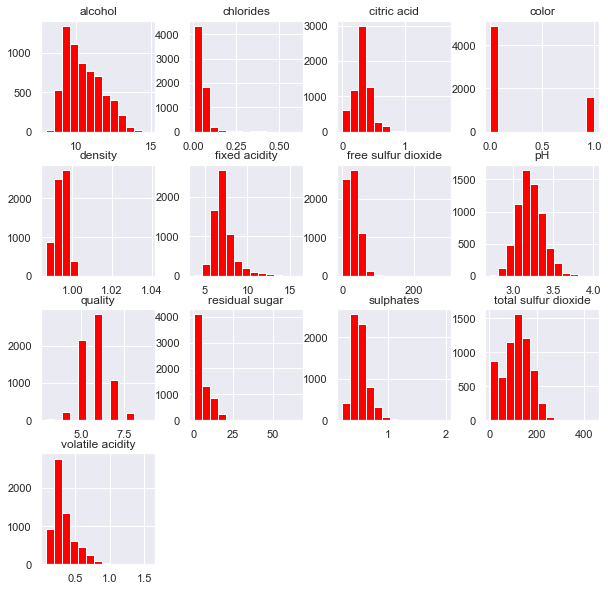

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

#sns.pairplot(data, diag_kind='hist',hue='color')
#sns.pairplot(data)

# show the histograms of values per feature (eg most of whines are at about 8 proof strength)
sns.set()
data.hist(figsize=(10,10),color='red', bins=13)
plt.show()

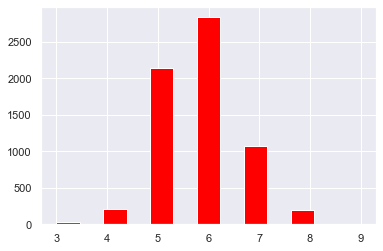

In [3]:
# show the historgram of wine rankings (quality between 1 and 10)
data['quality'].hist(color='red', bins=13)
plt.show()

In [4]:
# now let's try to find the most important features by using PCA
# first off drop off the non-chemical features.
data = data.drop(columns=['color','quality'])
fields = list(data.columns)
print(fields)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


[27.54 50.21 64.36 73.18 79.72 85.24 90.   94.56 97.62 99.69 99.99]


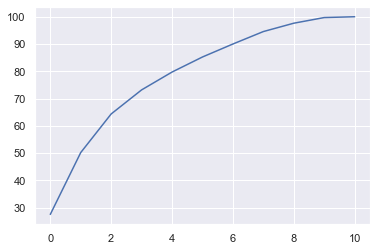

In [5]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
%matplotlib inline

X = data[fields]
X = scale(X)

pca = PCA(n_components=11)

pca.fit(X)

var= pca.explained_variance_ratio_

var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

print(var1)
plt.plot(var1)

pca = PCA(n_components=9)
pca.fit(X)
X1=pca.fit_transform(X)

#print(X1)

# the component with the lowest contribution is at 28% whihc is still significant to be dropped off 

In [6]:
import pandas as pd
import numpy as np

data_red = pd.read_csv(REDWINE_PATH,sep=',')
data_red['color'] = 1 #redwine

print(data_red.shape)

data_white = pd.read_csv(WHITEWINE_PATH,sep=',')
data_white['color'] = 0 #whitewine

print(data_white.shape)

data = data_red.merge(data_white, how='outer')


# based on the "quality histograms" above, we will drop the ratings with low counts (we will keep only 5,6,7)
data = data.drop(data[data.quality == 1].index)    # not recorded anyway
data = data.drop(data[data.quality == 2].index)    # not recorded anyway
data = data.drop(data[data.quality == 10].index)   # not recorded anyway
data = data.drop(data[data.quality == 9].index)
data = data.drop(data[data.quality == 3].index)
data = data.drop(data[data.quality == 8].index)
data = data.drop(data[data.quality == 4].index)

(1599, 13)
(4898, 13)


In [7]:
data.quality.value_counts()

6    2836
5    2138
7    1079
Name: quality, dtype: int64

In [8]:
fields = list(data.columns)
print(fields)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'color']


In [9]:
# split the data set in two: 1) color+features (observations)  2) quality (actuals)

fields = list(data.columns[:-2])
fields.append('color')  #adding color back
X = data[fields]
y = data['quality']
print(fields)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'color']


A Pearson correlation was used to identify which features correlate with wine quality. It looks as if higher the alcohol content the higher the quality. Lower density and volatile acidity also correlated with better quality as seen in the pairwise correlation chart the chart below. Only the top 5 correlated features were carried over to the SVM models.

In [10]:
correlations = data[fields].corrwith(y)
correlations.sort_values(inplace=True)

# the following fields are the 5 retained as having the highest correlations to wine quality
fields = correlations.map(abs).sort_values().iloc[-5:].index
print(fields) #prints the top two abs correlations

Index(['color', 'chlorides', 'volatile acidity', 'density', 'alcohol'], dtype='object')


[(-1.0, 1.0), Text(0, 0.5, 'pearson correlation')]

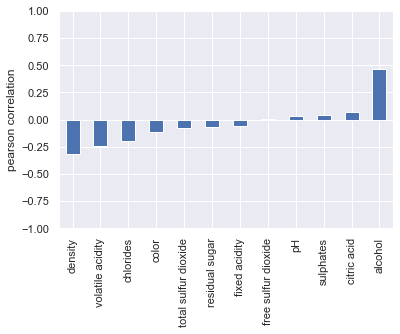

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# The figure below shows Pearson Pairwise correlation of features to wine quality.
# Looks like alcohol and density are the most correlated with quality
ax = correlations.plot(kind='bar')
ax.set(ylim=[-1, 1], ylabel='pearson correlation')

In [12]:
from sklearn.preprocessing import MinMaxScaler

X = data[fields]

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=['%s_scaled' % fld for fld in fields])
print(X.columns) #scaled columns

Index(['color_scaled', 'chlorides_scaled', 'volatile acidity_scaled',
       'density_scaled', 'alcohol_scaled'],
      dtype='object')


We will run now Support Vector Machines (SVM) to create a "prediction model"

SVM converges faster when features are scaled. If the model is senstive to magnitudes its generally a good idea to scale so one feature doesn’t get more influence than the other(in terms of scale).

In [13]:
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# we will split the data in training (70%) and testing (30%) whihc is the usual ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

Use GridSearchCV to tune hyperparameters for the SVM.

A Machine Learning model is defined as a mathematical model with a number of parameters that need to be learned from the data. However, there are some parameters, known as Hyperparameters and those cannot be directly learned. They are commonly chosen by human based on some intuition or hit and trial before the actual training begins. These parameters exhibits their importance by improving performance of the model such as its complexity or its learning rate. Models can have many hyper-parameters and finding the best combination of parameters can be treated as a search problem.

SVM also has some hyper-parameters (like what C or gamma values to use) and finding optimal hyper-parameter is a very hard task to solve. But it can be found by just trying all combinations and see what parameters work best. The main idea behind it is to create a grid of hyper-parameters and just try all of their combinations (hence, this method is called Gridsearch, But don’t worry! we don’t have to do it manually because Scikit-learn has this functionality built-in with GridSearchCV.

GridSearchCV takes a dictionary that describes the parameters that could be tried on a model to train it. The grid of parameters is defined as a dictionary, where the keys are the parameters and the values are the settings to be tested.

In [14]:
import time

parameters = {'kernel':('linear', 'rbf'), 'C':[.1, 1, 10], 'gamma':[.5, 1, 2, 10]}

startproc = time.time()

SVC_Gaussian = svm.SVC(gamma='scale')
gscv = GridSearchCV(SVC_Gaussian, param_grid=parameters, cv=5)
gscv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.5, 1, 2, 10],
                         'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [15]:
# Printing the best parameters.

print(gscv.best_estimator_)
print(gscv.best_params_)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
{'C': 10, 'gamma': 10, 'kernel': 'rbf'}


In [16]:
# Use the above parameters to train the SVM model

SVC_Gaussian = svm.SVC(kernel='rbf', gamma=10, C=1)
SVC_Gaussian.fit(X_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [17]:
# predict the wine rankings for the test data set

y_pred = SVC_Gaussian.predict(X_test)

proctime = time.time() - startproc

print(y_pred,X_test)

[7 5 6 ... 5 6 5]       color_scaled  chlorides_scaled  volatile acidity_scaled  density_scaled  \
4744           0.0          0.048173                    0.200        0.083285   
647            1.0          0.101329                    0.280        0.256217   
2173           0.0          0.061462                    0.080        0.138616   
2107           0.0          0.059801                    0.168        0.194525   
799            1.0          0.176080                    0.464        0.176981   
...            ...               ...                      ...             ...   
3413           0.0          0.079734                    0.208        0.148255   
174            1.0          0.169435                    0.184        0.192597   
1518           0.0          0.059801                    0.152        0.267785   
1192           1.0          0.116279                    0.416        0.154810   
4638           0.0          0.071429                    0.200        0.182379   

      alc

In [18]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Calculate the accuracy of prediction
metrics = list()
cm = dict()

# Precision, recall, f-score from the multi-class support function
precision, recall, fscore, _ = score(y_test, y_pred, average='weighted')

# The usual way to calculate accuracy
accuracy = accuracy_score(y_test, y_pred)


metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                          'fscore':fscore, 'accuracy':accuracy}, 
                         name='Model'))

metrics = pd.concat(metrics, axis=1)

print(metrics)

Model
precision  0.583204
recall     0.571035
fscore     0.541352
accuracy   0.571035


In [19]:
y_pred = SVC_Gaussian.predict(X_test)
print(y_pred)

[7 5 6 ... 5 6 5]


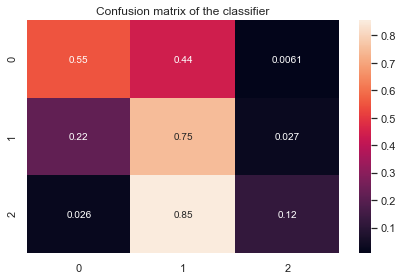

In [20]:
import matplotlib.pyplot as plt


# Last, the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#axList = axList.flatten()
#fig.set_size_inches(15, 15)

#axList[-1].axis('off')

sns.heatmap(cm, annot=True, fmt='.2g');
plt.title('Confusion matrix of the classifier')    
plt.tight_layout()

In [22]:
import sys, os

summaryfile = 'ModelsFitness.txt'
nbdir = os.getcwd()
fsummary = open(f'{nbdir}\\{summaryfile}',"a") 
fsummary.write('Wine Quality Analysis with Support Vector Machine\tProcessing (sec):{:.4f}\tAccuracy: {:.4f}\tF1-Score: {:.4f}\r\n'.format(proctime,accuracy,fscore))
fsummary.close() 